In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import torch
import sys, os, psutil, gc
import numpy as np, pandas as pd, itertools
import datetime
from tqdm import tqdm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

current_path = rf"{os.getcwd()}"
main_path = os.path.abspath(os.path.dirname(current_path))
sys.path.append(rf"{main_path}")
sys.path.append(rf"{main_path}/src")

import utilities as util
import baysian_ntk_utils as bays_util

torch.cuda.is_available()
os.environ['CASTLE_BACKEND'] = 'pytorch'

# icacls "C:\Users\mulugetawa\.conda\envs\dqm_py38_prod" /grant Everyone:F /t

c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-28 21:04:24,637 - c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-11-28 21:04:24,700 - c:\Users\mulugetawa\.conda\envs\dqm_py38_prod\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# Setup

In [3]:
main_path
DATASET = "EasyVista"
fig_dirpath = rf"{main_path}/results/"
datafilename = f"{DATASET}/causal_data/"
# datafilename = "dummy_causal_data"
util.Path(rf"{fig_dirpath}/{datafilename}").mkdir(exist_ok=True, parents=True)
data_affix = ""
data_sample_tag = "idx"

tObj = util.ProcTimer()
sns.set()
sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 1.})

def set_binary_ax_lims(ax):
    for ax_sub in ax:
     _ = ax_sub.set_yticks([0, 1])

'c:\\Users\\mulugetawa\\OneDrive - Universitetet i Agder\\CERN\\InductionProject\\AnomalyCD'

# EasyRCA Dataset

,LMB,ESB,PMDB,CMB,MDB,MB,GSIB,RTMB
45683,0.824,0.009,0.007,0.342,0.475,0.647,0.665,0.002
45684,0.822,0.009,0.007,0.340,0.482,0.671,0.662,0.002
45685,0.829,0.010,0.007,0.346,0.475,0.658,0.659,0.002
45686,0.838,0.011,0.007,0.346,0.467,0.663,0.655,0.002
45687,0.829,0.010,0.007,0.348,0.461,0.664,0.653,0.002


(4318, 8)

101


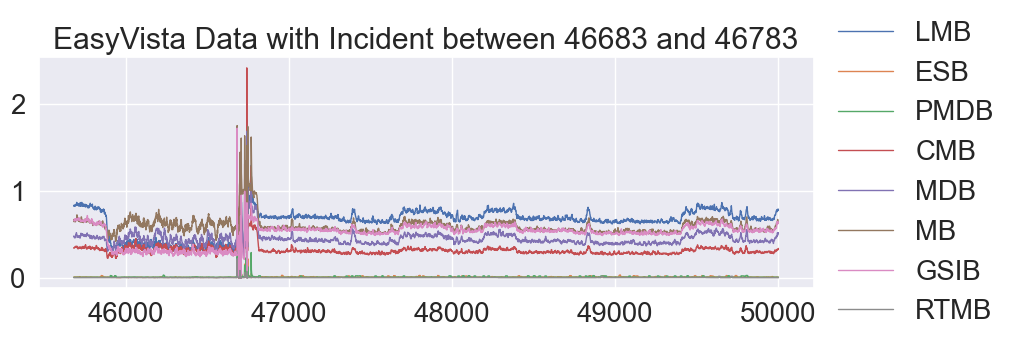

In [4]:
easycd_df = pd.read_csv(rf"{main_path}/data/EasyVista/data_with_incident_between_46683_and_46783.csv", sep=';', header=0, index_col=0)
map_name_to_abb = {
                    "capacity_last_metric_bolt": "LMB",
                    "capacity_elastic_search_bolt": "ESB",
                    "pre_Message_dispatcher_bolt": "PMDB",
                    "check_message_bolt": "CMB",
                    "message_dispatcher_bolt": "MDB",
                    "metric_bolt": "MB",
                    "group_status_information_bolt": "GSIB",
                    "Real_time_merger_bolt": "RTMB"
                    }

easycd_df.rename(map_name_to_abb, axis=1, inplace=True)
easycd_df.head()
easycd_df.shape
list_nodes = list(easycd_df.columns)

fig = easycd_df.plot(figsize=(10, 3), legend=True, title="EasyVista Data with Incident between 46683 and 46783")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

anomaly_start = 46683
anomaly_end = 46783
nb_anomalous_data = anomaly_end - anomaly_start + 1
print(nb_anomalous_data)

# OD

In [5]:
from online_tsad import OnlineTSAD

In [6]:
data_affix = ""
anomaly_start, anomaly_end
i_idx_list = easycd_df.reset_index().index
anomaly_start_end_i_idx = i_idx_list[easycd_df.index.isin([anomaly_start, anomaly_end])].values.tolist()
anomaly_start_end_i_idx

(46683, 46783)

[1000, 1100]

In [7]:
od_kwargs = dict(
            od_alg=["sr"],
            sr_th=2,
            sr_sampling_rate=1*4*60, # lower value sr_sampling_rate=12*1, and higher sr_th =11, detects freq changes
            score_window_size=1*8*60,
            series_window_size=1*1*60,
            clean_small_noises=False,
            verbose=0
        )
objODEngine = OnlineTSAD()
df_outlier_rm, df_raw = objODEngine.inference(easycd_df, **od_kwargs)
plot_dfs, marker_dfs, non_lbl_cols = objODEngine.prepare_plot_dfs(df_raw, df_outlier_rm, isfragment_flag_handle=True)

                            01_LMB  02_ESB  03_PMDB  04_CMB  05_MDB  06_MB  07_GSIB  08_RTMB
2025-11-28 21:04:43.800710   0.824   0.009    0.007   0.342   0.475  0.647    0.665    0.002
2025-11-28 21:05:43.800710   0.822   0.009    0.007   0.340   0.482  0.671    0.662    0.002
2025-11-28 21:06:43.800710   0.829   0.010    0.007   0.346   0.475  0.658    0.659    0.002
2025-11-28 21:07:43.800710   0.838   0.011    0.007   0.346   0.467  0.663    0.655    0.002
2025-11-28 21:08:43.800710   0.829   0.010    0.007   0.348   0.461  0.664    0.653    0.002
data shape:  (4318, 8)
################################################################################
['sr']...
ts outliers detection... sr
preparing normal signal after removing outliers...
algorithms: stat_sigma, sr, ml, pca, msd, mes, tsd, prophet, drift_prophet drift_tsd drift
missing data (before outlier cleaning): (0, 8)
local outlier detection: sr ...
sampling_rate=240, amp_window_size=240, series_window_size=60, score_window_siz

100%|██████████| 8/8 [00:00<00:00, 321.65it/s]


missing data (after outlier cleaning): (0, 8)
Number of missing data in df_outlier: 
0    4318
dtype: int64
Number of OD flags in df_outlier: 
01_LMB_OL_LBL     103
02_ESB_OL_LBL     276
03_PMDB_OL_LBL    349
04_CMB_OL_LBL      77
05_MDB_OL_LBL      72
06_MB_OL_LBL       65
07_GSIB_OL_LBL     63
08_RTMB_OL_LBL    165
dtype: int64
################################################################################
aggregating outlier flags (sum)...


100%|██████████| 8/8 [00:00<00:00, 427.18it/s]


['SR__01_LMB_OL_LBL']
0    4215
1     103
Name: 01_LMB_OL_LBL, dtype: int64
['SR__02_ESB_OL_LBL']
0    4042
1     276
Name: 02_ESB_OL_LBL, dtype: int64
['SR__03_PMDB_OL_LBL']
0    3969
1     349
Name: 03_PMDB_OL_LBL, dtype: int64
['SR__04_CMB_OL_LBL']
0    4241
1      77
Name: 04_CMB_OL_LBL, dtype: int64
['SR__05_MDB_OL_LBL']
0    4246
1      72
Name: 05_MDB_OL_LBL, dtype: int64
['SR__06_MB_OL_LBL']
0    4253
1      65
Name: 06_MB_OL_LBL, dtype: int64
['SR__07_GSIB_OL_LBL']
0    4255
1      63
Name: 07_GSIB_OL_LBL, dtype: int64
['SR__08_RTMB_OL_LBL']
0    4153
1     165
Name: 08_RTMB_OL_LBL, dtype: int64
                            01_LMB  02_ESB  03_PMDB  04_CMB  05_MDB  06_MB  07_GSIB  08_RTMB  SR__01_LMB_OL_SCORE  SR__02_ESB_OL_SCORE  SR__03_PMDB_OL_SCORE  SR__04_CMB_OL_SCORE  SR__05_MDB_OL_SCORE  SR__06_MB_OL_SCORE  SR__07_GSIB_OL_SCORE  SR__08_RTMB_OL_SCORE  01_LMB_OL_LBL  02_ESB_OL_LBL  03_PMDB_OL_LBL  04_CMB_OL_LBL  05_MDB_OL_LBL  06_MB_OL_LBL  07_GSIB_OL_LBL  08_RTMB_OL_LBL
202

100%|██████████| 8/8 [00:00<00:00, 553.97it/s]

['01_LMB_OL_LBL']
01_LMB: num_outlier: 103
['02_ESB_OL_LBL']
02_ESB: num_outlier: 276
['03_PMDB_OL_LBL']
03_PMDB: num_outlier: 349
['04_CMB_OL_LBL']
04_CMB: num_outlier: 77
['05_MDB_OL_LBL']
05_MDB: num_outlier: 72
['06_MB_OL_LBL']
06_MB: num_outlier: 65
['07_GSIB_OL_LBL']
07_GSIB: num_outlier: 63
['08_RTMB_OL_LBL']
08_RTMB: num_outlier: 165
process time: 0.08260130882263184 seconds.


### OD Plots

plotting... may take few minutes depending on data size. Disable use_timestamp=False for further processing with index based x-axis.
saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//EasyVista/causal_data/EasyVista_od_idx_marked.jpg


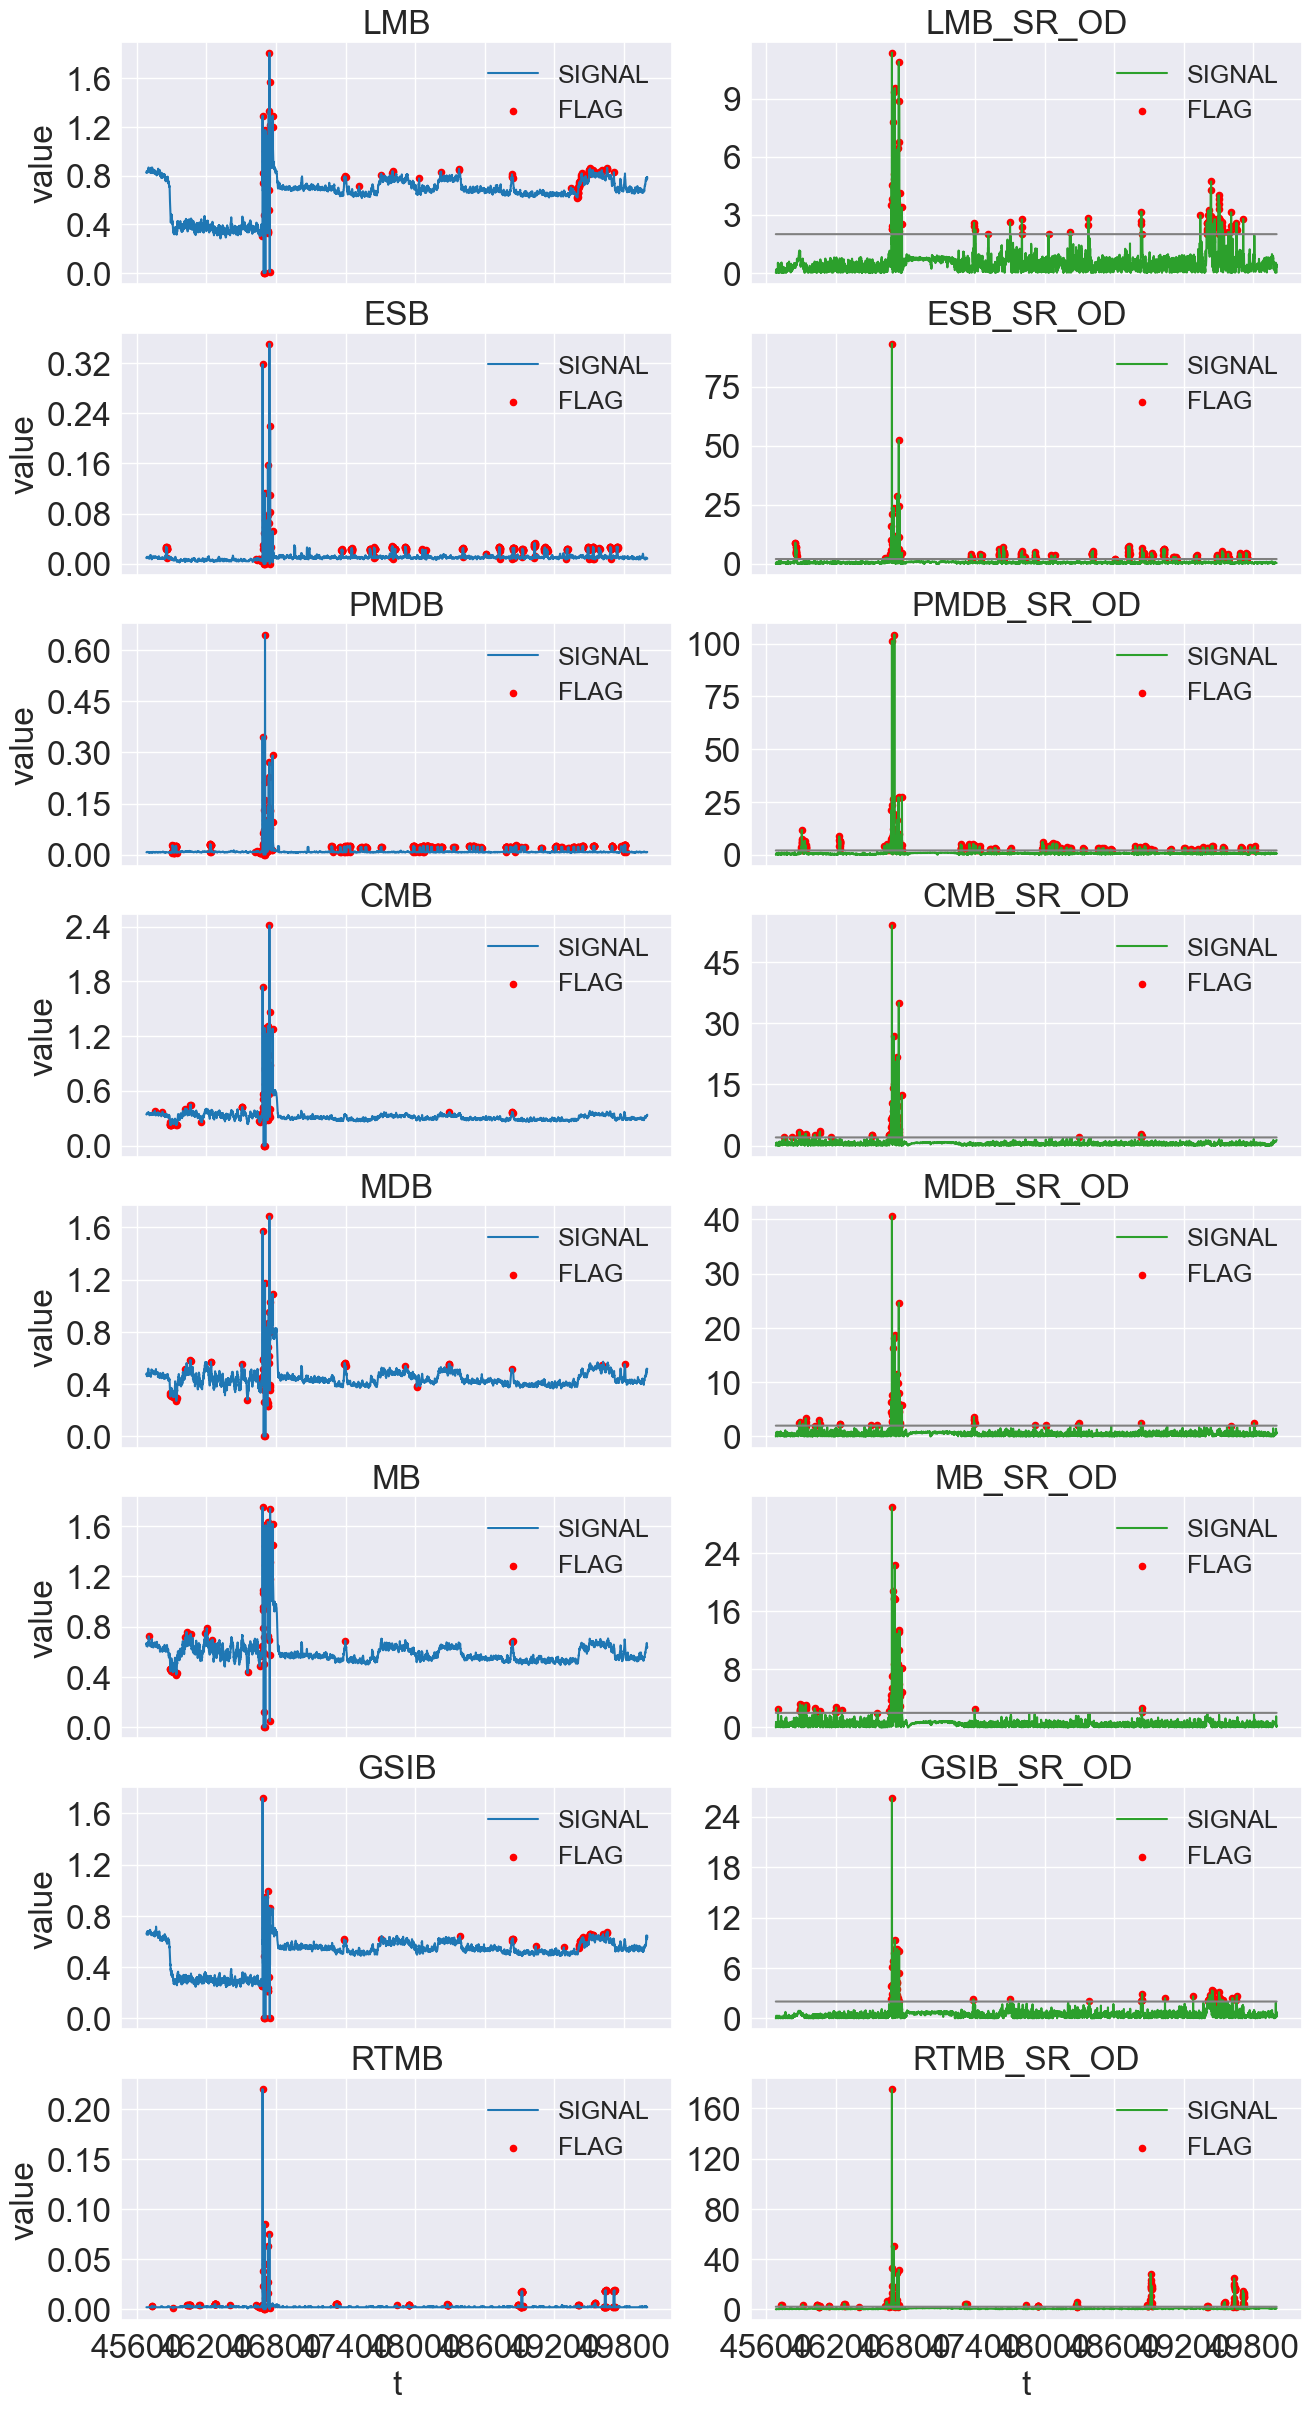

In [8]:
fig = OnlineTSAD.plot_od_results_ts_with_markers(df_raw, df_outlier_rm, 
                                      system_col=None, 
                                      sel_system=None, 
                                      sel_sensor=None,
                                      data_gap_dates=None,
                                      od_kwargs=od_kwargs)
util.save_figure(f"{datafilename}{DATASET}_od_{data_sample_tag}_marked", fig,
                 filepath=fig_dirpath, isshow=True, issave=True, dpi=100)

### Prepare Agg OD Flag Dataset

In [9]:
df_aml = objODEngine.get_agg_multi_od_flags(df_raw, df_outlier_rm, ops_mask=None)

100%|██████████| 9/9 [00:00<?, ?it/s]


saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results//EasyVista/causal_data/EasyVista_od_flag_count.jpg


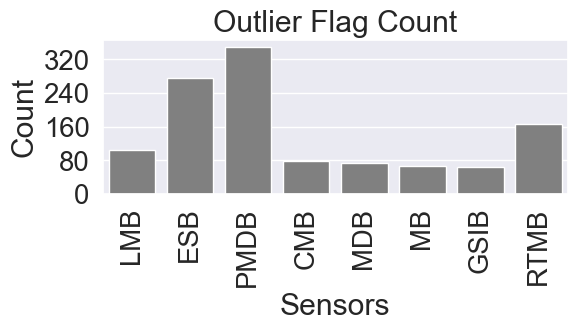

In [10]:
# plot flag count
sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 1.})
aml_count_df = df_aml.sum(axis=0).to_frame().reset_index(drop=False)
aml_count_df.columns = ["Sensors", "Count"]
aml_count_df["Sensors"] = aml_count_df["Sensors"].apply(
    lambda x: x.replace("__OUTLIER_FLAG", ""))
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.barplot(x="Sensors", y="Count",
                 data=aml_count_df, ax=ax, color="gray")
_ = ax.set_title("Outlier Flag Count")
_ = plt.xticks(rotation=90)
locator = util.ticker.MaxNLocator(5)
_ = ax.yaxis.set_major_locator(locator)
util.save_figure(f"{datafilename}{DATASET}_od_flag_count", fig,
                 filepath=fig_dirpath, isshow=True, issave=True, dpi=100)
sns.set()

### Prepare and Store Binary Data

In [11]:
#  Save binary anomaly flag data
df_aml.isna().sum(axis=0)
df_aml_rca = df_aml.copy()
df_aml_rca[df_aml_rca > 0] = 1
df_aml_rca.shape
util.save_csv(f"{datafilename}{DATASET}_od_binary_anomaly_flag_data.csv", df_aml_rca, filepath=fig_dirpath)

LMB     0
ESB     0
PMDB    0
CMB     0
MDB     0
MB      0
GSIB    0
RTMB    0
dtype: int64

(4318, 8)

saving  c:\Users\mulugetawa\OneDrive - Universitetet i Agder\CERN\InductionProject\AnomalyCD/results///EasyVista/causal_data/EasyVista_od_binary_anomaly_flag_data.csv


## Correlation Analysis, with $\tau_{max}=5$ and Compression Data ${l_m=10}$

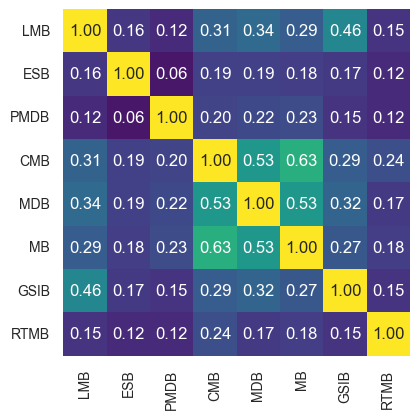

In [ ]:
def get_corr_score(df):
    _corr_matrix = df.astype("float64").corr().astype("float64")
    _corr_matrix = _corr_matrix.applymap(lambda x: 0.0 if x < 0 else np.round(x, 2))
    # _corr_matrix
    varnames = df.columns
    vmin = 0.0
    vmax = 1.0
    fmt = "0.2f"
    iscbar = False
    fontsize = 10
    plt.figure(figsize=(4.5,4.5))
    with sns.axes_style("white"):
        ax = sns.heatmap(_corr_matrix.values, vmin=vmin, vmax=vmax, 
                            square=True,
                            annot=True, fmt=fmt, 
                            # cbar_kws=cbar_kws, 
                            cbar=iscbar, 
                            cmap='viridis',
                            ax=None
                        ) 
        _ = ax.set_xticklabels(varnames, rotation=90, fontsize=fontsize)
        _ = ax.set_yticklabels(varnames, rotation=0, fontsize=fontsize)

        plt.show()
    return _corr_matrix

_corr_matrix = get_corr_score(df_aml_rca)

sparse_data_handler...data_mode: flag:  {'keep_len': 5}
Input data size: (4318, 8), new size: (1348, 8). The rate of compression by 68.78%


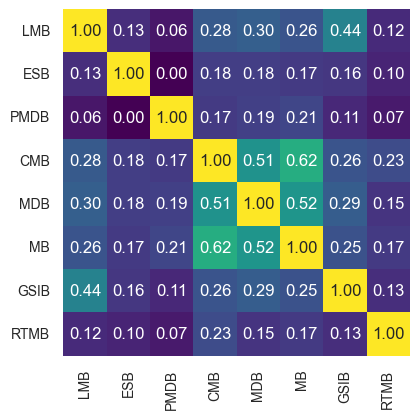

sparse_data_handler...data_mode: flag:  {'keep_len': 10}
Input data size: (4318, 8), new size: (1938, 8). The rate of compression by 55.12%


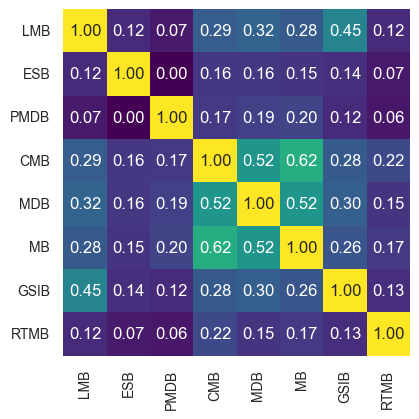

sparse_data_handler...data_mode: flag:  {'keep_len': 15}
Input data size: (4318, 8), new size: (2308, 8). The rate of compression by 46.55%


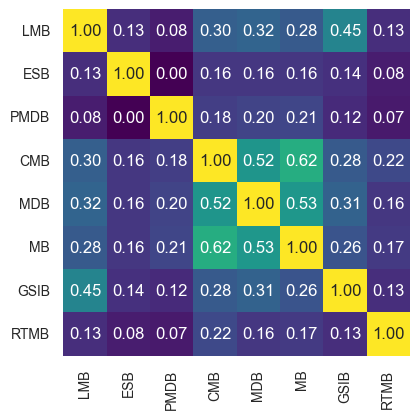

sparse_data_handler...data_mode: flag:  {'keep_len': 20}
Input data size: (4318, 8), new size: (2585, 8). The rate of compression by 40.13%


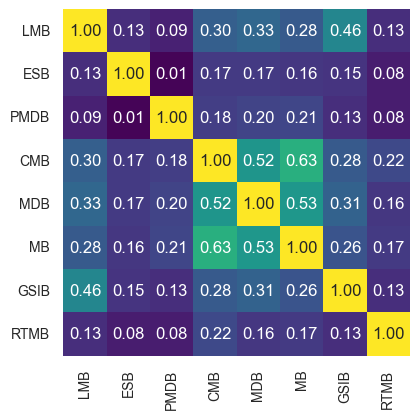

sparse_data_handler...data_mode: flag:  {'keep_len': 25}
Input data size: (4318, 8), new size: (2800, 8). The rate of compression by 35.16%


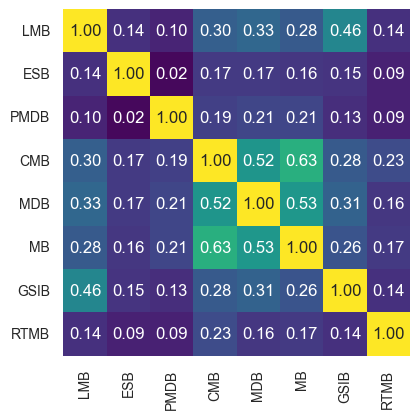

sparse_data_handler...data_mode: flag:  {'keep_len': 30}
Input data size: (4318, 8), new size: (2957, 8). The rate of compression by 31.52%


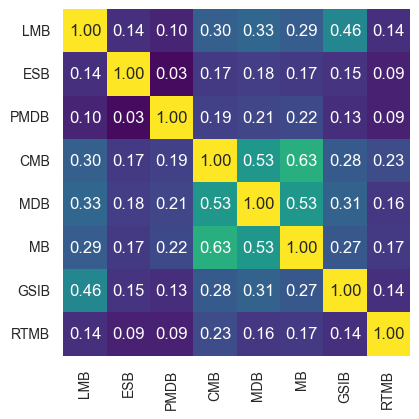

sparse_data_handler...data_mode: flag:  {'keep_len': 35}
Input data size: (4318, 8), new size: (3081, 8). The rate of compression by 28.65%


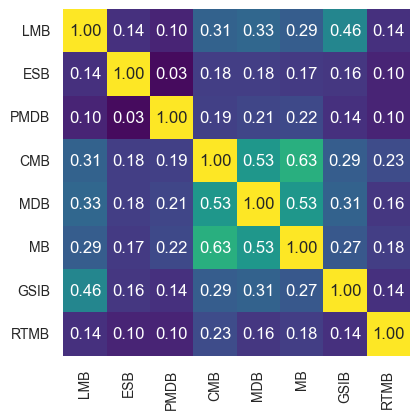

sparse_data_handler...data_mode: flag:  {'keep_len': 40}
Input data size: (4318, 8), new size: (3193, 8). The rate of compression by 26.05%


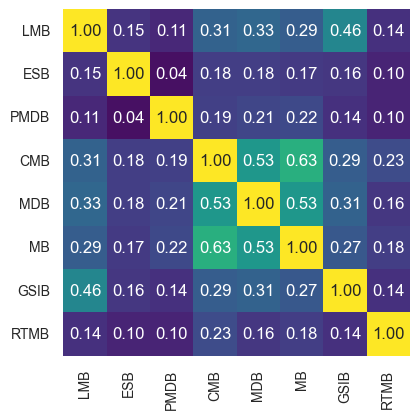

sparse_data_handler...data_mode: flag:  {'keep_len': 45}
Input data size: (4318, 8), new size: (3295, 8). The rate of compression by 23.69%


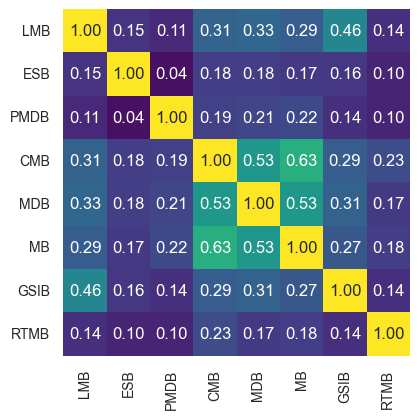

sparse_data_handler...data_mode: flag:  {'keep_len': 50}
Input data size: (4318, 8), new size: (3368, 8). The rate of compression by 22.0%


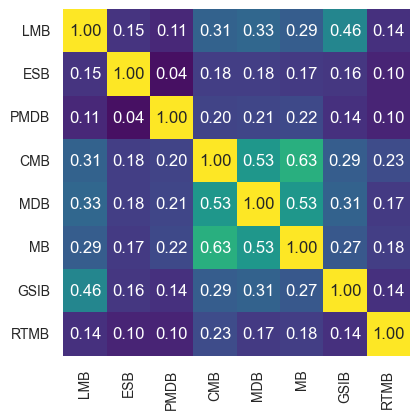

In [ ]:
# data compression affects the correlation
for keep_len in range(5, 51, 5):
    _df_aml_compressed = bays_util.sparse_data_handler(
                                    df_aml_rca.copy().fillna(0), data_mode="flag", keep_len=keep_len) 
    _corr_matrix = get_corr_score(_df_aml_compressed)